In [2]:
# base 
import pandas as pd
import numpy as np
import dill

# data exploration
import matplotlib.pyplot as plt
import seaborn as sns
import shap
%matplotlib inline
from pylab import rcParams

rcParams['figure.figsize'] = 16, 16
# color = sns.color_palette()

# data preparation
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest,chi2,RFE
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer

# models
from sklearn.linear_model import Ridge
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, train_test_split

# metrics
from scipy import stats
from sklearn.metrics import roc_auc_score, r2_score, roc_curve, mean_absolute_error
from sklearn.inspection import permutation_importance
import shap
shap.initjs()

## **Get Data**

In [3]:
pd.set_option('display.max_columns', 500)

TRAIN = 'train.csv'
TEST = 'test.csv'

data = pd.read_csv(TRAIN)
test_df = pd.read_csv(TEST)

print('TRAIN shape:', data.shape)
print('TEST shape:', test_df.shape)

TRAIN shape: (30471, 292)
TEST shape: (7662, 291)


In [66]:
with open('features_names.txt', 'w') as f:
    text = ' '.join(data.drop(['price_doc'], axis=1).columns.tolist())
    f.write(text)

In [4]:
df = data.copy()

## **Data Exploration**

### **Data Quality**

In [294]:
df.describe().round(1)

,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road2_km,ID_big_road2,railroad_km,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,cafe_avg_price_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_4000,cafe_count_2000_price_high,big_church_count_2000,church_count_2000,mosque_count_2000,leisure_c

_**Plot target distribution**_

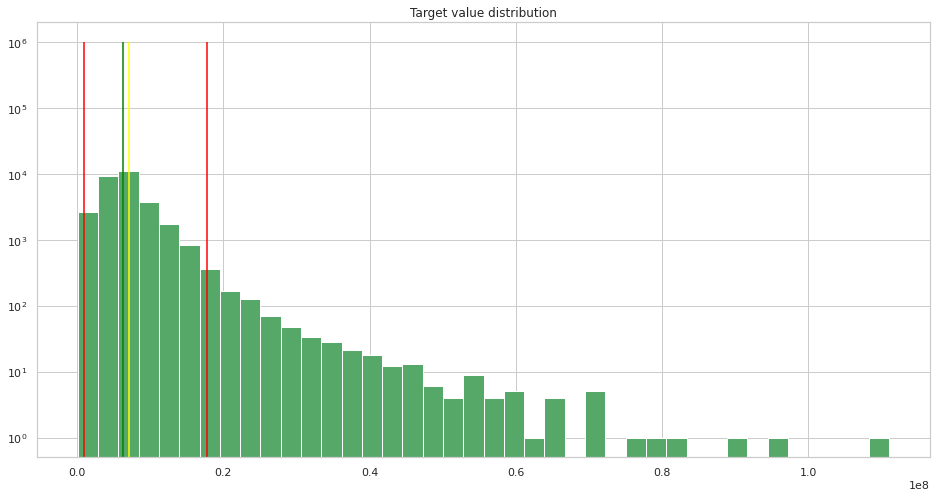

In [295]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(16, 8))
plt.hist(df['price_doc'], color='g', bins=40, log=True);
plt.vlines(x=df.price_doc.quantile(.01), ymin=0, ymax=10e5, color='red')
plt.vlines(x=df.price_doc.quantile(.975), ymin=0, ymax=10e5,color='red')
plt.vlines(x=df.price_doc.mean(), ymin=0, ymax=10e5,color='yellow')
plt.vlines(x=df.price_doc.median(),ymin=0, ymax=10e5, color='green')

plt.title('Target value distribution');

_**Plot floor distribution**_

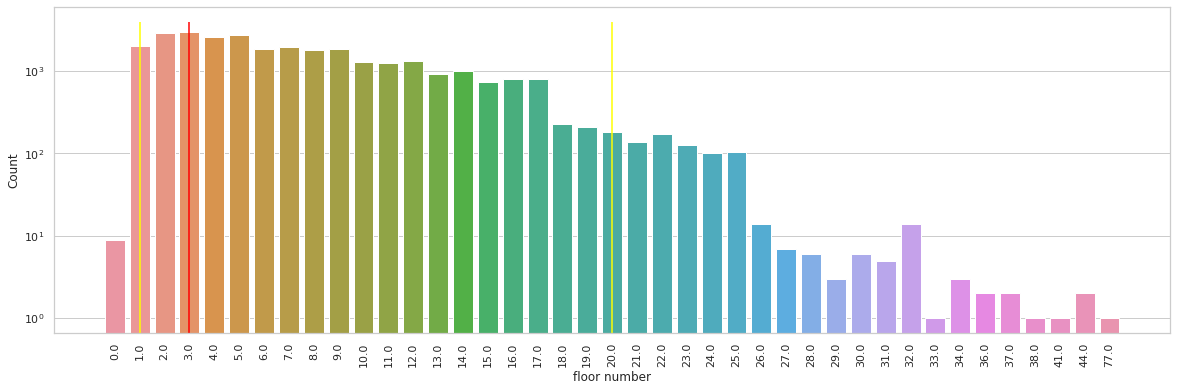

In [296]:
plt.figure(figsize=(20,6))
sns.countplot(x="floor", data=df).set_yscale('log')
plt.vlines(x=df.floor.mode(),ymin=0, ymax=4000, color='red')
plt.vlines(x=df.floor.quantile(.975),ymin=0, ymax=4000, color='yellow')
plt.vlines(x=df.floor.quantile(.01),ymin=0, ymax=4000, color='yellow')

plt.ylabel('Count', fontsize=12)
plt.xlabel('floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

_**Plot life_square distribution**_

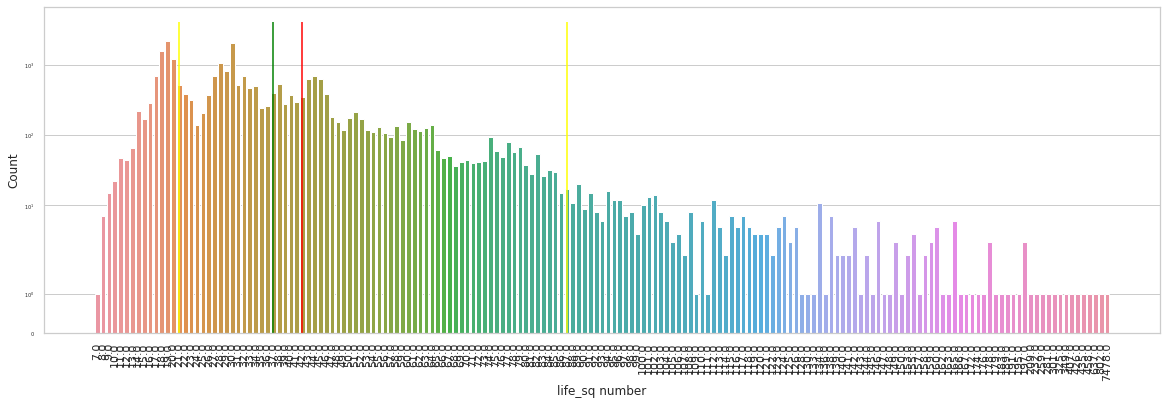

In [297]:
df_copy = df.copy()
df_copy.life_sq.replace({0.0: df.life_sq.median(), 1.0: df.life_sq.median()}, inplace=True)
plt.figure(figsize=(20,6))
sns.countplot(x="life_sq", data=df_copy).set_yscale('symlog')

plt.vlines(x=df_copy.life_sq.median(),ymin=0, ymax=4000, color='green')
plt.vlines(x=df_copy.life_sq.mean(),ymin=0, ymax=4000, color='red')

plt.vlines(x=df_copy.life_sq.quantile(.975),ymin=0, ymax=4000, color='yellow')
plt.vlines(x=df_copy.life_sq.quantile(.01),ymin=0, ymax=4000, color='yellow')

plt.ylabel('Count', fontsize=12)
plt.yticks(fontsize=5)
plt.xlabel('life_sq number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

_**Let's look at the dependence of the target variable on such characteristics as kitchen area, living area and floor**_

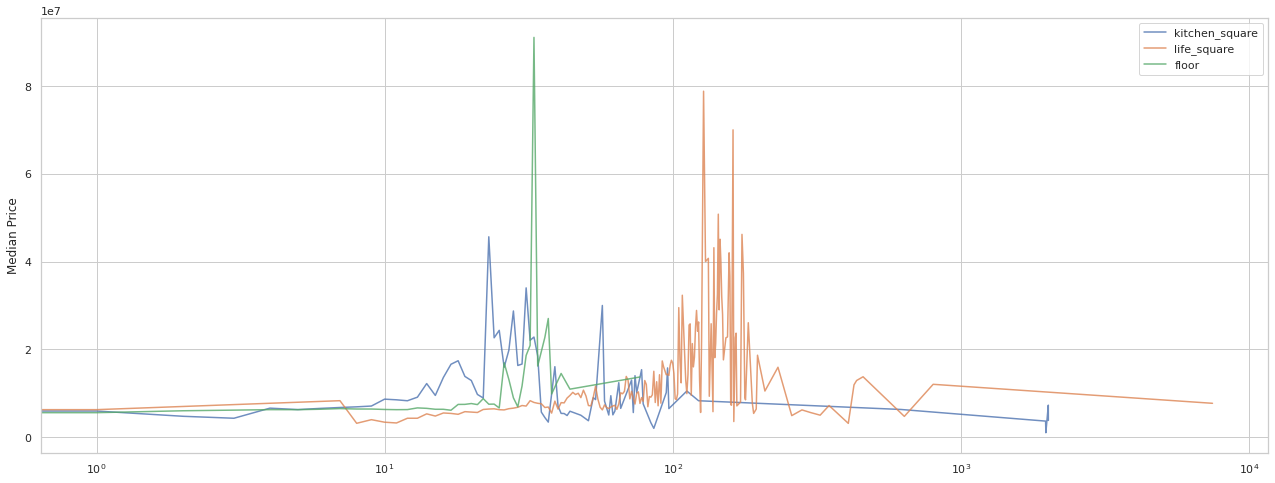

In [298]:
grouped_kitch = df.groupby('kitch_sq')['price_doc'].aggregate(np.median).reset_index()
grouped_life = df.groupby('life_sq')['price_doc'].aggregate(np.median).reset_index()
grouped_floor = df.groupby('floor')['price_doc'].aggregate(np.median).reset_index()

f, ax = plt.subplots(1, 1, figsize=(22,8))
ax.plot(grouped_kitch.kitch_sq.values, 
              grouped_kitch.price_doc.values, 
              alpha=0.8, 
              label='kitchen_square')
ax.plot(grouped_life.life_sq.values, 
              grouped_life.price_doc.values, 
              alpha=0.8, 
              label='life_square')
ax.plot(grouped_floor.floor.values, 
              grouped_floor.price_doc.values, 
              alpha=0.8, 
              label='floor')

ax.set_xscale('log')
plt.ylabel('Median Price', fontsize=12)

plt.legend()
plt.show()

In [299]:
# seems like this feature is not categorical - it's rating of material, ordinal value
df[df.material == 1.0].price_doc.mean(),df[df.material == 6.0].price_doc.mean()

(7088091.297105022, 7979828.4470734745)

_**Plot some dependencies**_

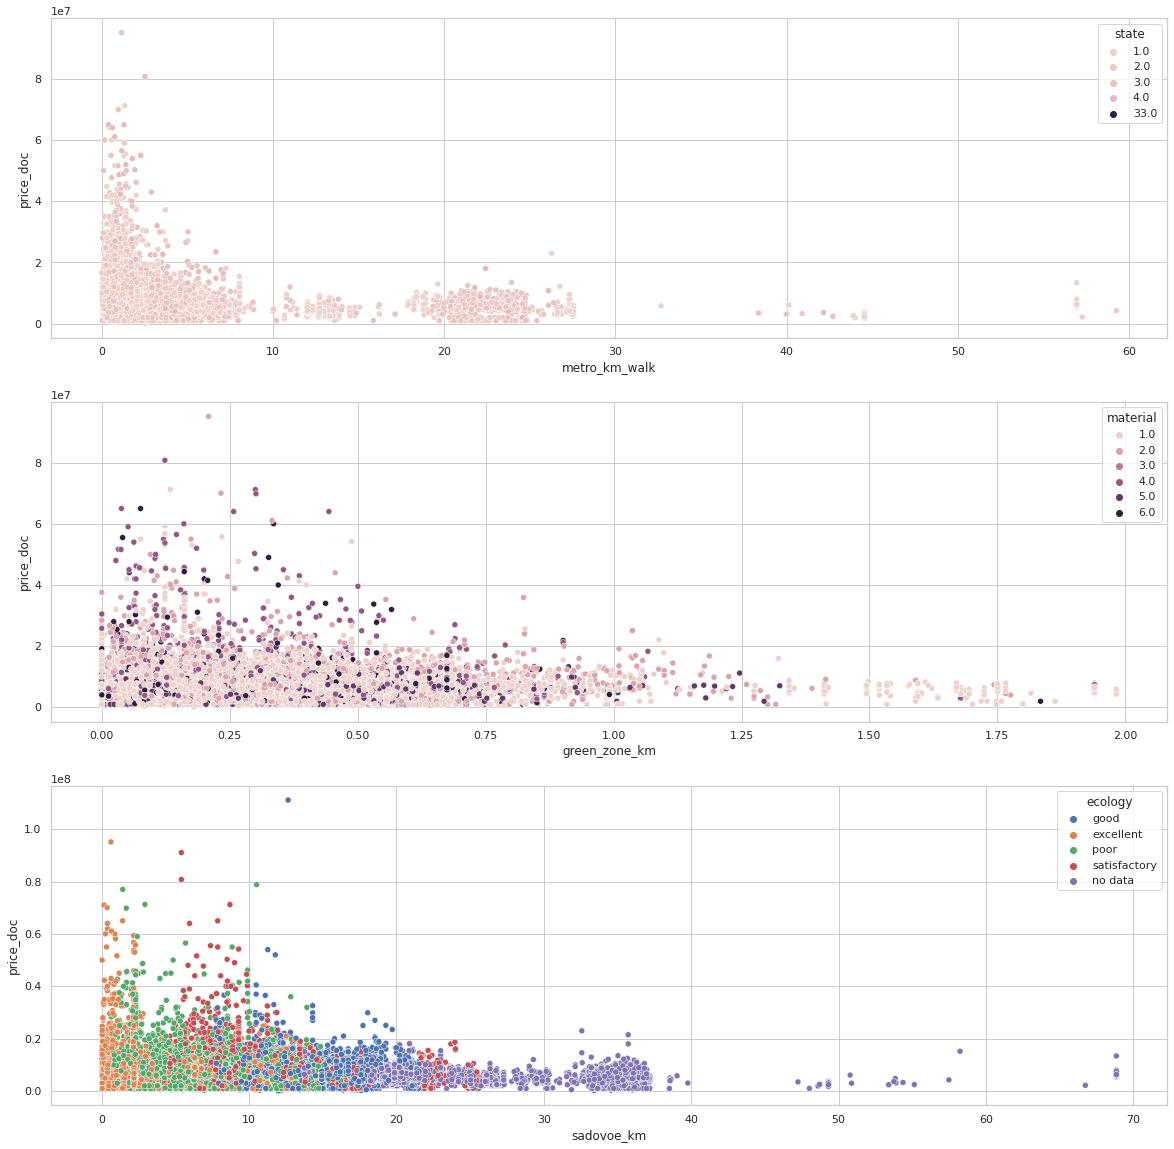

In [300]:
f, ax = plt.subplots(3, 1, figsize=(20, 20), sharex=False)
sns.scatterplot(x=df.metro_km_walk, y=df.price_doc, data=df, hue='state', ax=ax[0]);
sns.scatterplot(x=df.green_zone_km, y=df.price_doc, data=df, hue='material', ax=ax[1]);
sns.scatterplot(x=df.sadovoe_km, y=df.price_doc, data=df, hue='ecology', ax=ax[2]);

### **Feature Types**

##### **Object Features**

In [301]:
df.select_dtypes(include='object_').head()

,timestamp,product_type,sub_area,culture_objects_top_25,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line,ecology
0,2011-08-20,Investment,Bibirevo,no,no,no,no,no,no,no,no,no,no,no,no,good
1,2011-08-23,Investment,Nagatinskij Zaton,yes,no,no,no,no,no,no,no,no,no,no,no,excellent
2,2011-08-27,Investment,Tekstil'shhiki,no,no,no,no,yes,no,no,no,no,no,no,no,poor
3,2011-09-01,Investment,Mitino,no,no,no,no,no,no,no,no,no,no,no,no,good
4,2011-09-05,Investment,Basmannoe,no,no,no,no,yes,yes,no,no,no,no,no,yes,excellent


##### **Binary Features**

In [302]:
for col in df.columns:
    if df[col].nunique() == 2:
        print(col, df[col].unique())

product_type ['Investment' 'OwnerOccupier']
culture_objects_top_25 ['no' 'yes']
thermal_power_plant_raion ['no' 'yes']
incineration_raion ['no' 'yes']
oil_chemistry_raion ['no' 'yes']
radiation_raion ['no' 'yes']
railroad_terminal_raion ['no' 'yes']
big_market_raion ['no' 'yes']
nuclear_reactor_raion ['no' 'yes']
detention_facility_raion ['no' 'yes']
water_1line ['no' 'yes']
big_road1_1line ['no' 'yes']
railroad_1line ['no' 'yes']
mosque_count_500 [0 1]
mosque_count_1000 [0 1]
mosque_count_1500 [0 1]
mosque_count_2000 [0 1]


_Actual binary features contain values [no, yes]._

In [303]:
# it seems state should be a rate between 1 and 5, I'm going to fix it
df['state'] = df.state.replace({33.:5.})
df.state.unique()

array([nan,  3.,  1.,  2.,  4.,  5.])

##### **Numerical Features**

In [304]:
# ID columns
id_columns = df.loc[:, (df.columns.str.startswith('ID')| df.columns.str.startswith('id'))]
for d in id_columns:
    print(d, df[d].nunique())

id 30471
ID_metro 223
ID_railroad_station_walk 133
ID_railroad_station_avto 133
ID_big_road1 48
ID_big_road2 58
ID_railroad_terminal 8
ID_bus_terminal 14


In [305]:
print('continous features:')
df.select_dtypes(include=['float64']).shape[1]

continous features:


119

In [306]:
print('total number of numerical features:')
df.select_dtypes(include=['float64', 'int64']).shape[1]

total number of numerical features:


276

##### **Apartment Characterictics**

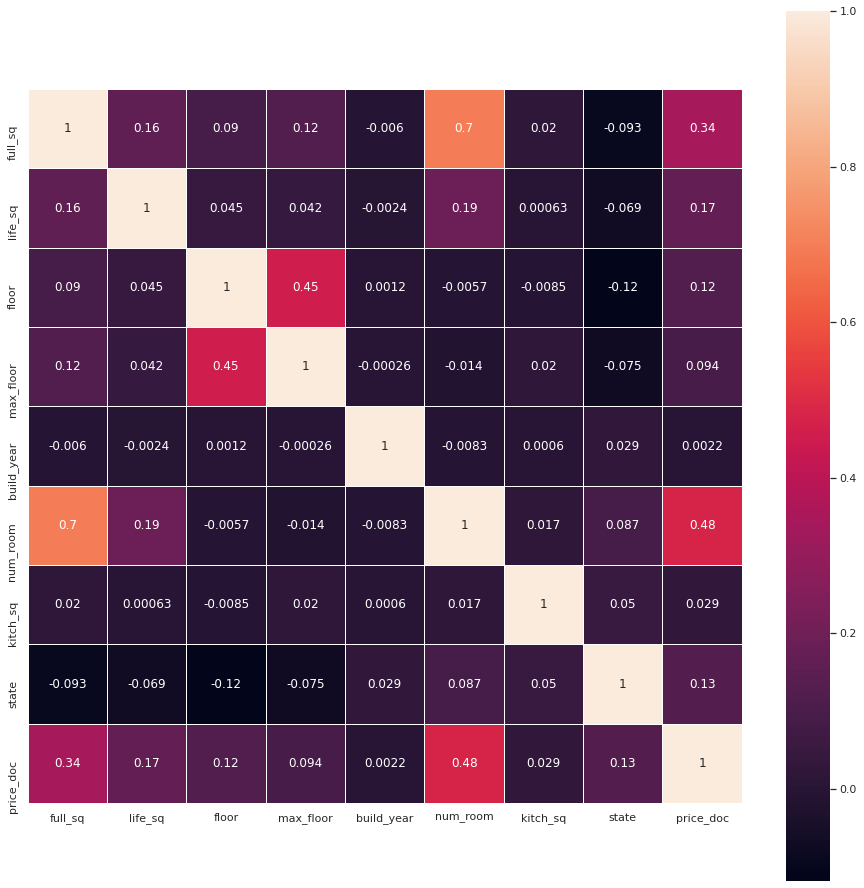

In [307]:
internal_feats = ['full_sq', 'life_sq', 'floor', 'max_floor', 'build_year', 'num_room', 'kitch_sq', 'state', 'price_doc']

sns.heatmap(df[internal_feats].corr(), square=True, linewidths=.5, annot=True);

**_Plot correlation matrix of numerical features having correlation coefficient greater than 0.2_**

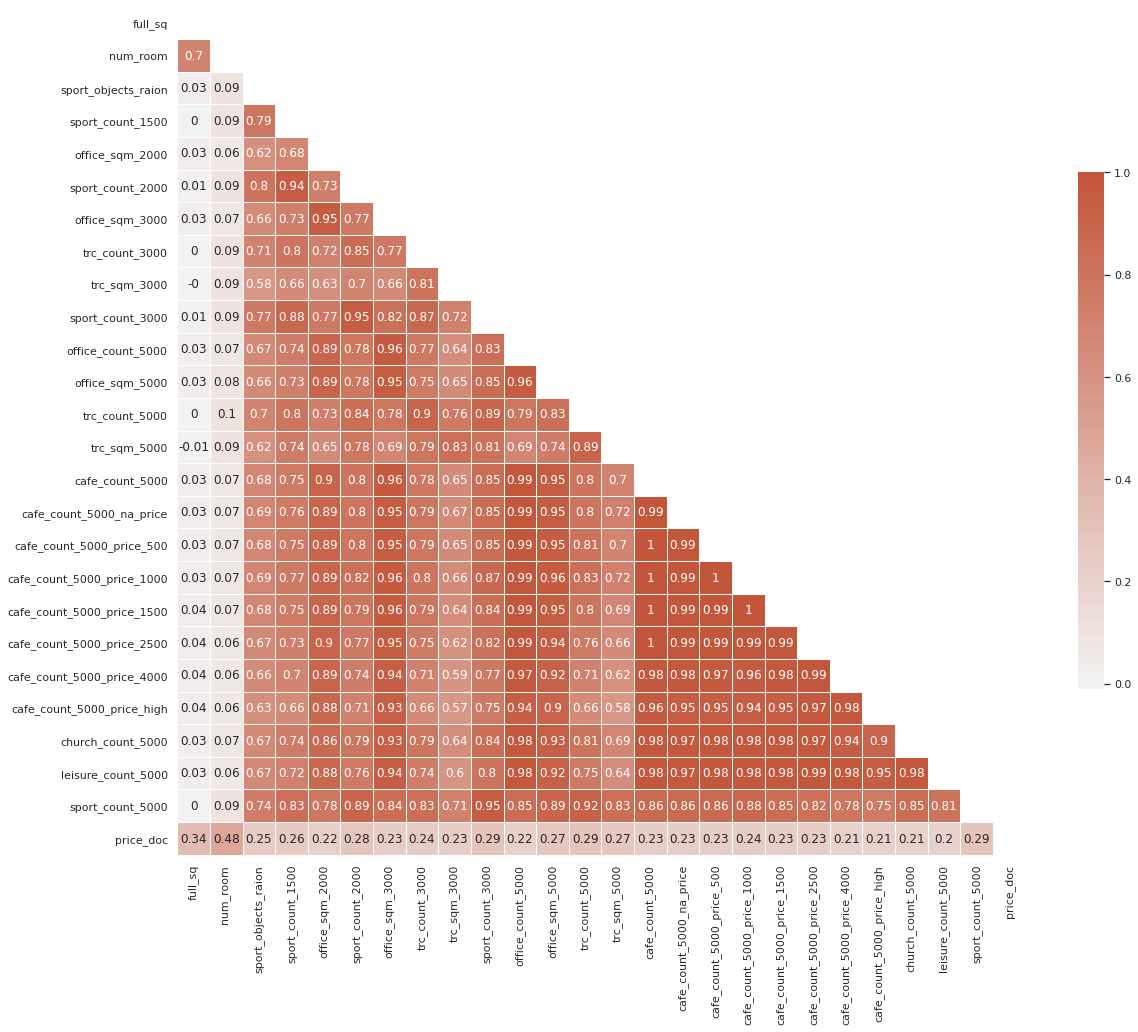

In [308]:
corr = df.select_dtypes(include=['int64', 'float64']).corr()

corr = corr[corr.price_doc > 0.2]
cols_select = corr.index
corr = corr[cols_select].round(2)

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(19, 19))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap,center=0, vmax=1, square=True, linewidths=.5, cbar_kws={'shrink': .5}, annot=True);

### **Missing Values**

In [309]:
df_na = df.isna().sum()[df.isna().sum() > 0]

print("Number of features containing NaNs: {}".format(df_na.count()))
print("Total number of NaNs: {} or {}%".format(df_na.sum(), (df_na.sum()/df.size).round(3)))

Number of features containing NaNs: 51
Total number of NaNs: 261026 or 0.029%


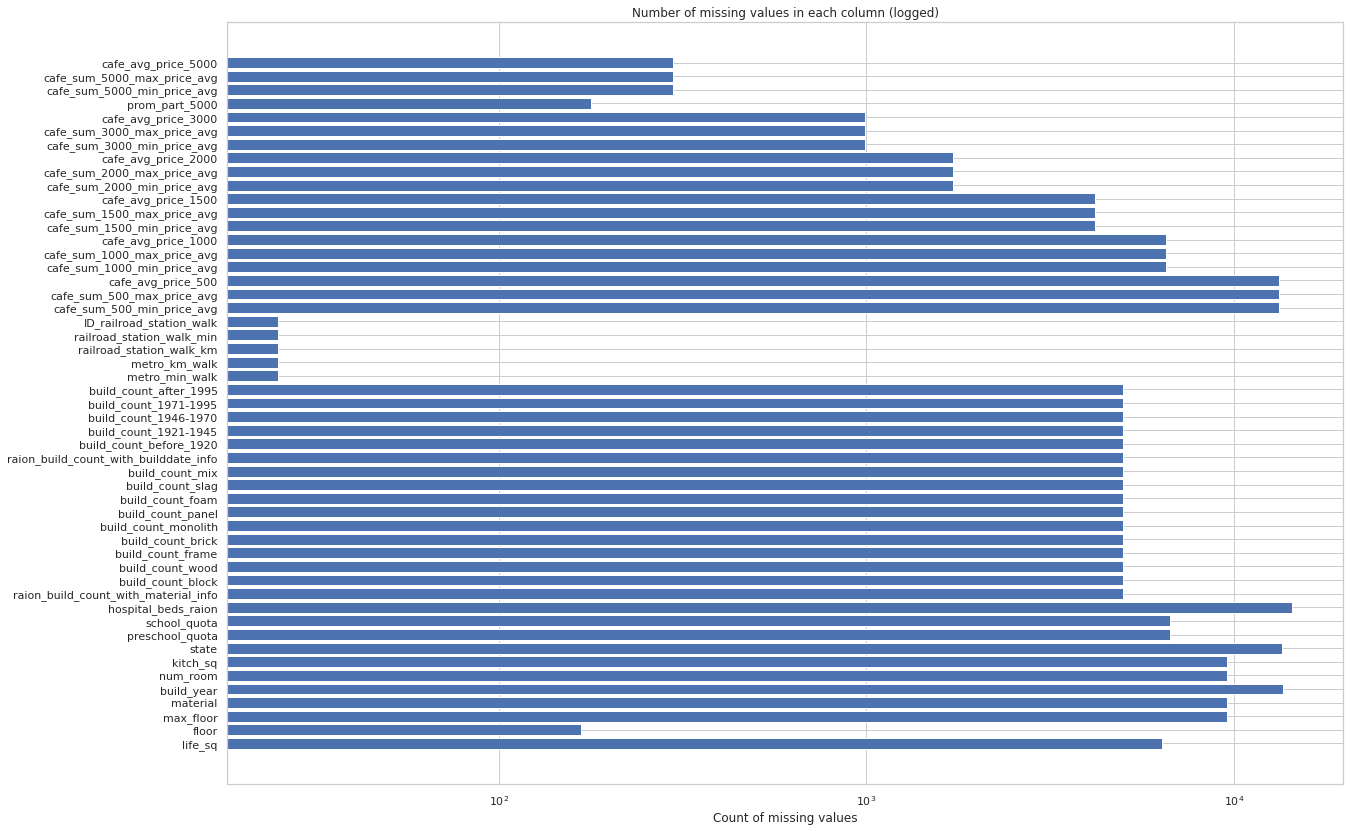

In [310]:
missing_df = df.isna().sum(axis=0).reset_index()
missing_df.columns = ['col', 'missing_count']

missing_df = missing_df[missing_df.missing_count > 0]

ind = np.arange(missing_df.shape[0])

fig, ax = plt.subplots(figsize=(20,14))
ax.barh(ind, missing_df.missing_count, log=True)
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.col.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column (logged)");

## **Feature Engineering**

In [311]:
df.drop('id', axis=1, inplace=True)
df['timestamp'] = pd.to_datetime(df.timestamp)

num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
obj_cols = df.select_dtypes(include=['object']).columns.tolist()

timedata =  ['timestamp']
binary_feats = [col for col in obj_cols 
             if df[col].dropna().unique().all() in ['yes', 'no']]
id_columns = df.loc[:, (df.columns.str.startswith('ID')| df.columns.str.startswith('id'))].columns.tolist()
ordinal_feats = ['ecology']
categorical_feats = list(set(obj_cols) - set(binary_feats) - set(ordinal_feats))
numerical_feats = list(set(num_cols) - set(id_columns))


print('number of timedata features: {}'.format(len(timedata)))
print('number of numerical features: {}'.format(len(numerical_feats)))
print('number of categorical features: {}'.format(len(categorical_feats)))
print('number of binary features: {}'.format(len(binary_feats)))
print('number of ordinal features: {}'.format(len(ordinal_feats)))
print('Total features number: {}'.format(len(df.columns)))


number of timedata features: 1
number of numerical features: 268
number of categorical features: 2
number of binary features: 12
number of ordinal features: 1
Total features number: 291


In [312]:
categorical_feats, binary_feats

(['sub_area', 'product_type'],
 ['culture_objects_top_25',
  'thermal_power_plant_raion',
  'incineration_raion',
  'oil_chemistry_raion',
  'radiation_raion',
  'railroad_terminal_raion',
  'big_market_raion',
  'nuclear_reactor_raion',
  'detention_facility_raion',
  'water_1line',
  'big_road1_1line',
  'railroad_1line'])

In [313]:
print('number of sub_area unique:')
df.sub_area.nunique()

number of sub_area unique:


146

### **Outliers**

In [314]:
df.area_m.clip(df.area_m.quantile(0.1), df.area_m.quantile(.975), inplace=True)

In [315]:
print('num_room stats')
print('quantile 1%: {}; quantile 97.5%: {}'.format(df.num_room.quantile(.01), 
                                                   df.floor.quantile(.975)))
print('moda: {}; median: {}; mean: {}'.format(df.num_room.mode()[0], 
                                              df.num_room.median(),
                                              df.num_room.mean()))

df['num_room'].clip(df.num_room.quantile(.05),
                    df.num_room.quantile(.975))

df.num_room.fillna(df.num_room.mode()[0], inplace=True)

num_room stats
quantile 1%: 1.0; quantile 97.5%: 20.0
moda: 2.0; median: 2.0; mean: 1.909804296856309


In [316]:
print('floor stats')
print('quantile 1%: {}; quantile 97.5%: {}'.format(df.floor.quantile(.01), 
                                                   df.floor.quantile(.975)))
print('moda: {}; median: {}; mean: {}'.format(df.floor.mode()[0], 
                                              df.floor.median(),
                                              df.floor.mean()))

df.loc[(df.floor < df.floor.quantile(.1)) | 
    (df.floor > df.floor.quantile(.99)), 'floor'] = np.NaN

df.floor.fillna(df.floor.mode()[0], inplace=True)

floor stats
quantile 1%: 1.0; quantile 97.5%: 20.0
moda: 3.0; median: 6.5; mean: 7.670802534318902


In [317]:
print('life_sq stats')
print('quantile 1%: {}; quantile 97.5%: {}'.format(df.life_sq.quantile(.01), 
                                                   df.life_sq.quantile(.975)))
print('moda: {}; median: {}; mean: {}'.format(df.life_sq.mode()[0], 
                                              df.life_sq.median(),
                                              df.life_sq.mean()))

df.loc[(df.life_sq < df.life_sq.quantile(.05)) | 
    (df.life_sq > df.life_sq.quantile(.9)), 'life_sq'] = np.NaN

df.life_sq.fillna(df.life_sq.median(), inplace=True)

life_sq stats
quantile 1%: 1.0; quantile 97.5%: 80.0
moda: 19.0; median: 30.0; mean: 34.403271338425775


In [318]:
print('kitch_sq stats')
print('quantile 1%: {}; quantile 97.5%: {}'.format(df.kitch_sq.quantile(.01), 
                                                   df.kitch_sq.quantile(.975)))
print('moda: {}; median: {}; mean: {}'.format(df.kitch_sq.mode()[0], 
                                              df.kitch_sq.median(),
                                              df.kitch_sq.mean()))

df.loc[(df.kitch_sq < df.kitch_sq.quantile(.1)) | 
    (df.kitch_sq > df.kitch_sq.quantile(.975)), 'kitch_sq'] = np.NaN

df['kitch_sq'] = df.kitch_sq.fillna(df.kitch_sq.median())

kitch_sq stats
quantile 1%: 0.0; quantile 97.5%: 13.0
moda: 1.0; median: 6.0; mean: 6.399301401980956


In [319]:
df.build_year.replace({0.0: np.NaN, 1.0: np.NaN}, inplace=True)
print('build_year stats')
print('quantile 0.01%: {}; quantile 99.9%: {}'.format(df.build_year.quantile(.01), 
                                                   df.build_year.quantile(.999)))
print('moda: {}; median: {}; mean: {}'.format(df.build_year.mode()[0], 
                                              df.build_year.median(),
                                              df.build_year.mean()))

df['build_year'] = df.build_year.clip(df.build_year.quantile(.01), 
                                      df.build_year.quantile(.999))

df.build_year.describe()

build_year stats
quantile 0.01%: 1936.0; quantile 99.9%: 2017.0
moda: 2014.0; median: 1981.0; mean: 3240.5738351703408


count    15968.000000
mean      1985.490356
std         20.471707
min       1936.000000
25%       1968.000000
50%       1981.000000
75%       2006.000000
max       2017.000000
Name: build_year, dtype: float64

In [320]:
# timedata feature engineering
df['timestamp'] = pd.to_datetime(df.timestamp)
df['transaction_year'] = df.timestamp.dt.year
df['transaction_month'] = df.timestamp.dt.month
df['transaction_day'] = df.timestamp.dt.day
df['transaction_day_of_week'] = df.timestamp.dt.dayofweek
df = df.drop('timestamp', axis=1)

In [321]:
# since it's ordinal data may be encoded with numbers
df.ecology.unique()

array(['good', 'excellent', 'poor', 'satisfactory', 'no data'],
      dtype=object)

#### **Fill NaNs**

In [322]:
# fill kitch_sq NaNs with full_sq-kitch_sq relation
kitch_ratio = df['full_sq']/df['kitch_sq']
df['kitch_sq']=df['kitch_sq'].fillna(df['full_sq'] /kitch_ratio.median())

# fill life_sq NaNs with full_sq-life_sq relation
lifesq_ratio = df['full_sq']/df['life_sq']
df['life_sq']=df['life_sq'].fillna(df['full_sq'] /lifesq_ratio.median())

# fix full_sq where it's value less than life_sq values
lifesq = df[df.full_sq < df.life_sq].life_sq
df.loc[df.full_sq < df.life_sq, 'full_sq'] = lifesq

# fill max_floor and floor NaNs
df.max_floor.fillna(df.max_floor.mode()[0], inplace=True)
df.floor.fillna(df.floor.mode()[0], inplace=True)

# fix max_floor where it's values less than floor 
mfloors = df[df.floor > df.max_floor]['floor']
df.loc[df.floor > df.max_floor, 'max_floor'] = mfloors

In [323]:
df.material.fillna(df.material.mode()[0], inplace=True)

In [324]:
# encode categorical variables
tmp = df[categorical_feats]
for col in categorical_feats:
    t = pd.get_dummies(tmp[col], prefix=col)
    tmp = pd.concat([tmp.drop(col, axis=1), t], axis=1)

df = pd.concat([df.drop(categorical_feats, axis=1), tmp], axis=1)
categorical_feats = tmp.columns

# binarize feats with values [no, yes]
for col in binary_feats:
    df[col].replace({'yes': 1, 'no': 0}, inplace=True)

# fix state ranking and fill NaNs
df['state'] = df.state.replace({33.0: 5.0})
df.state.fillna(df.state.mode()[0], inplace=True)

# encode ordinal
df['ecology'] = df['ecology'].replace({'no data': 0, 'poor': 1, 'satisfactory': 2, 'good': 3, 'excellent': 4})

# fill NaNs remaining features 
i=0
for col in df.isna().sum()[df.isna().sum()>0].index:
    df[col].fillna(df[col].median(), inplace=True)
    i+=1
    if i % 10 == 0:
        print(i, 'features proccessed')

10 features proccessed
20 features proccessed
30 features proccessed
40 features proccessed


In [325]:
# encode numerical features
scaler = MinMaxScaler()
numerical = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
df[numerical] = scaler.fit_transform(df[numerical])

In [326]:
# PROBLEM
# Why does ColumnTransformer give an error of mismatching between the number of features it receives 
# and those that are passed to processing
set(data.sub_area.unique()) - set(test_df.sub_area.unique())

{'Poselenie Klenovskoe'}

## **Train-test Split**

In [327]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('price_doc', axis=1), 
                                                    df['price_doc'], 
                                                    test_size=.3)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21329, 439), (9142, 439), (21329,), (9142,))

## **Build Model**

In [328]:
# try simple linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print('r2_score:', r2_score(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

r2_score: -1.6876340281848748e+19
MAE: 1789393.149073689


In [329]:
# try RandomForest regression model
regressor = RandomForestRegressor(random_state=32)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

print('r2_score:', r2_score(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
df_rf = pd.DataFrame(regressor.feature_importances_)
df_rf.index = X_train.columns

# RandomForestRegressor feature importances
df_rf.sort_values(by=0,ascending=False).head(5)

r2_score: 0.6604382141003479
MAE: 0.012848055568991993


,0
full_sq,0.402398
cafe_count_2000_price_2500,0.031005
cafe_count_2000,0.030931
cafe_count_3000,0.029729
cafe_count_5000_price_2500,0.027296


In [330]:
# try gradient boosting model

gbr = GradientBoostingRegressor(random_state=12)
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)

print('r2_score:', r2_score(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

df_gbr = pd.DataFrame(gbr.feature_importances_)
df_gbr.index = X_train.columns

df_gbr.sort_values(by=0,ascending=False).head(5)

r2_score: 0.6501075183993303
MAE: 0.013609477616881766


,0
full_sq,0.545759
cafe_count_2000,0.049546
cafe_count_3000_price_2500,0.043619
cafe_count_2000_price_2500,0.026863
cafe_count_5000_price_2500,0.026569


In [331]:
# try XGBoost regression model
xgb_regressor = XGBRegressor()
xgb_regressor.fit(X_train, y_train)
y_pred = xgb_regressor.predict(X_test)

print('r2_score:', r2_score(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

# XGBoostRegressor feature importances
df_xgb = pd.DataFrame(xgb_regressor.feature_importances_)
df_xgb.index = X_train.columns
df_xgb.sort_values(by=0, ascending=False).head()

r2_score: 0.6632713875180598
MAE: 0.012950404424504802


,0
cafe_count_3000_price_2500,0.119311
cafe_count_3000_price_1500,0.072834
cafe_count_2000,0.064182
cafe_count_5000_price_2500,0.051807
cafe_count_1500_price_4000,0.038670


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


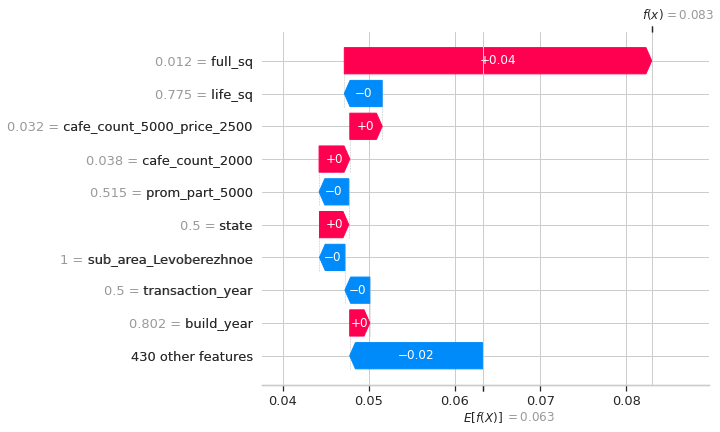

In [332]:
explainer = shap.TreeExplainer(xgb_regressor)
shap_values = explainer.shap_values(X_test)
shap_values = explainer(X_test)
shap.plots.waterfall(shap_values[0])

_It may seem that simpler models (GradientBoostingRegressor, RandomForestRegressor) showed the best result, but according to the final predictions from the test dataset, it is ExtraGradientBoostingRegressor that gives the least errors - I submitted the results for three different models to kaggle to figure it out._

## **Model Tuning**

In [56]:
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}
xgbr = XGBRegressor(seed = 20)
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)
clf.fit(X_train, y_train)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 1000}
Lowest RMSE:  0.02471658308973694


## **Build Pipeline**

In [50]:
X_train = data.drop('price_doc', axis=1)
y_train = data['price_doc']
X_test = test_df

In [51]:
X = X_train.copy()
X['timestamp'] = pd.to_datetime(X.timestamp)
num_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
obj_cols = X.select_dtypes(include=['object']).columns.tolist()

binary_feats = [col for col in obj_cols 
             if X[col].dropna().unique().all() in ['yes', 'no']]
ordinal_feats = ['ecology']
timedata = ['timestamp']
timedata_after_encode = ['timestamp_year', 'timestamp_month', 'timestamp_day', 'timestamp_dayofweek']
categorical_feats = ['sub_area', 'product_type', 'material']
numerical_feats = list(set(num_cols) - set(categorical_feats) - set(['id']))
all_feats = binary_feats+ordinal_feats+timedata+categorical_feats+numerical_feats
categorical_cols_after_encode = []
for col in categorical_feats:
    new_cols = pd.get_dummies(X[col], prefix=col).columns.tolist()
    categorical_cols_after_encode += new_cols

print('INITIAL VARIABLES COUNTS:')
print(f'bin count: {len(binary_feats)}')
print(f'ord count: {len(ordinal_feats)}')
print(f'dt count: {len(timedata)}')
print(f'cat count: {len(categorical_feats)}')
print(f'num count: {len(numerical_feats)}')
print(f'total: {len(binary_feats) + len(ordinal_feats) + len(timedata) + len(categorical_feats) + len(numerical_feats)}')
print(f'expected after encode:', len(binary_feats)+len(ordinal_feats)+len(timedata_after_encode)+len(categorical_cols_after_encode)+len(numerical_feats))
print(f'except columns: {[col for col in data.columns.to_list() if col not in all_feats]}')

INITIAL VARIABLES COUNTS:
bin count: 12
ord count: 1
dt count: 1
cat count: 3
num count: 273
total: 290
expected after encode: 444
except columns: ['id', 'price_doc']


In [54]:
class NumericalFeaturesCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.imputer = SimpleImputer(strategy='median')
        return None

    def fit(self, X, y=None):
        self.imputer.fit(X)
        return self

    def impute_numerical(self, X):
        kitch_ratio = X['full_sq'] / X['kitch_sq']
        X['kitch_sq'] = X['kitch_sq'].fillna(X['full_sq'] / kitch_ratio.median())
        
        lifesq_ratio = X['full_sq'] / X['life_sq']
        X['life_sq'] = X['life_sq'].fillna(X['full_sq'] / lifesq_ratio)

        # fix observations where floor feature has higher value than max_floor
        mfloors = X[X['floor'] > X['max_floor']]['floor']
        X.loc[X['floor'] > X['max_floor'], 'max_floor'] = mfloors 

        mlifesq = X[X['full_sq'] < X['life_sq']]['life_sq']
        X.loc[X['full_sq'] < X['life_sq'], 'full_sq'] = mlifesq
        return X

    def remove_outliers(self, X):
        for col in X.columns:
            if col == 'state':
                X[col] = X[col].replace({33.0: 5.0})
                
            Q1 = X[col].quantile(0.1)
            Q3 = X[col].quantile(0.975)
            IQR = Q3 - Q1

            low = Q1 - 1.5 * IQR
            high = Q3 + 1.5 * IQR

            X[col] = np.where(X[col] < low, low, X[col])
            X[col] = np.where(X[col] > high, high, X[col])

        return X
     
    def transform(self, X, y=None):
 
        X = self.impute_numerical(X)
        X = self.remove_outliers(X)
        X = self.imputer.transform(X)
        return X


class CategoricalFeaturesCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.imputer = SimpleImputer(strategy='most_frequent')
        self.encoder = OneHotEncoder(sparse=False)

    def fit(self, X, y=None):
        self.imputer.fit(X)
        return self
    
    def transform(self, X, y=None):
        if X.sub_area.nunique() == 145: # look at X_train
            X.loc[0, 'sub_area'] = 'Poselenie Klenovskoe' # fix mismatching X_train and X_test features num
        X = self.imputer.transform(X)
        X = self.encoder.fit_transform(X)

        return X


class TimestampEncoding(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X[self.key] = pd.to_datetime(X[self.key])
        prefix = self.key
        X[f'{prefix}_year'] = X[self.key].dt.year
        X[f'{prefix}_month'] = X[self.key].dt.month
        X[f'{prefix}_day'] = X[self.key].dt.day
        X[f'{prefix}_day_of_week'] = X[self.key].dt.dayofweek
        X = X.drop(self.key, axis=1)

        return X
    

class BinaryEncoding(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.imputer = SimpleImputer(strategy='most_frequent')
        self.binary_dict = {'yes': 1, 'no': 0}
    
    def fit(self, X, y=None):
        self.imputer.fit(X)
        return self
    
    def transform(self, X, y=None):     
        X = X.replace(self.binary_dict)
        X = self.imputer.transform(X)
        return X


class OrdinalEncoding(BaseEstimator, TransformerMixin):
    def __init__(self, ordinal_values=['no data', 'poor', 'satisfactory', 'good', 'excellent']):
        self.imputer = SimpleImputer(strategy='most_frequent')
        self.ordinal_values = ordinal_values
        self.replace_dict = dict(zip(ordinal_values, range(0, len(ordinal_values))))
    
    def fit(self, X, y=None):
        self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        X = X.replace(self.replace_dict)
        X = self.imputer.transform(X)
        return X

columns = timedata_after_encode+binary_feats+ordinal_feats+categorical_cols_after_encode+numerical_feats

tf = ColumnTransformer(transformers=[
    ('timestamp', TimestampEncoding(key='timestamp'), ['timestamp']),
    ('binary', BinaryEncoding(), binary_feats),
    ('ordinal', OrdinalEncoding(), ['ecology']),
    ('cat_cleaner', CategoricalFeaturesCleaner(), categorical_feats),
    ('num_clean', NumericalFeaturesCleaner(), numerical_feats)
], remainder='drop')

scale_tf = ColumnTransformer(transformers=[
    ('scale', MinMaxScaler(), np.arange(0, len(columns)-1))
    ])

### **Fitting pipeline**

In [55]:
%%time
best_params = {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 1000}

X_train, y_train = data.drop(['price_doc', 'id'], axis=1), data['price_doc']

pipe = Pipeline(steps=[
    ('tf1', tf),
    ('scale', scale_tf),
    ('model', XGBRegressor(**best_params))
])
pipe.fit(X_train, y_train)

CPU times: user 1h 34min 1s, sys: 41.4 s, total: 1h 34min 42s
Wall time: 36min 9s


Pipeline(steps=[('tf1',
                 ColumnTransformer(transformers=[('timestamp',
                                                  TimestampEncoding(key='timestamp'),
                                                  ['timestamp']),
                                                 ('binary', BinaryEncoding(),
                                                  ['culture_objects_top_25',
                                                   'thermal_power_plant_raion',
                                                   'incineration_raion',
                                                   'oil_chemistry_raion',
                                                   'radiation_raion',
                                                   'railroad_terminal_raion',
                                                   'big_market_raion',
                                                   'nuclear_reactor_raion',
                                                   'detention_facility_r...
        

### **Save pipeline to .dill file**

In [56]:
with open('xgboost_pipeline.dill', 'wb') as f:
    dill.dump(pipe, f)

### **Setting up docker container**
`$ docker build -t sberbank-housing-market_docker_flask .`

`$ docker run -d -p 4140:4140 -v /home/alina/gb_ml_for_business/machine-learning-for-business/PROJECT-Sberbank-housing-market/models/:/app/app/models sberbank-housing-market_docker_flask`

## **Predict on test data**

In [57]:
dill._dill._reverse_typemap['ClassType'] = type

with open('models/xgboost_pipeline.dill', 'rb') as f:
    pipe = dill.load(f)

Trying to unpickle estimator SimpleImputer from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator OneHotEncoder from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator ColumnTransformer from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator MinMaxScaler from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator Pipeline from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.


In [71]:
import urllib.request
import json    
from urllib.error import HTTPError



class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

def get_features_dict(observation, filename='features_names.txt'):
    try:
        with open(filename, 'r') as f:
            feature_names = f.readlines()[0].split()
        print(len(feature_names))
    except:
        return """Feature names file does not exist"""

    features_dict = dict(zip(feature_names, observation))
    return features_dict

def get_predictions(body: dict):
    myurl = "http://0.0.0.0:4140/predict"
    jsondata = json.dumps(body, cls=NpEncoder)
    byte_jsondata = jsondata.encode('utf-8')
    headers = {'Content-Type': 'application/json; charset=utf-8',
               'Content-Length': len(byte_jsondata),
               'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.61 Safari/537.36'}
    req = urllib.request.Request(myurl, headers=headers)
    try:
        response = urllib.request.urlopen(req, byte_jsondata)
        print(response)
        return json.loads(response.read())['predictions']
    except HTTPError as e:
        return e.read()

to_predict = test_df.iloc[0].values
print(len(to_predict))
fd = get_features_dict(to_predict)
get_predictions(fd)

291
291


b'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN"\n  "http://www.w3.org/TR/html4/loose.dtd">\n<html>\n  <head>\n    <title>ValueError: Number of features of the input must be equal to or greater than that of the fitted transformer. Transformer n_features is 291 and input n_features is 290. // Werkzeug Debugger</title>\n    <link rel="stylesheet" href="?__debugger__=yes&amp;cmd=resource&amp;f=style.css"\n        type="text/css">\n    <!-- We need to make sure this has a favicon so that the debugger does\n         not by accident trigger a request to /favicon.ico which might\n         change the application state. -->\n    <link rel="shortcut icon"\n        href="?__debugger__=yes&amp;cmd=resource&amp;f=console.png">\n    <script src="?__debugger__=yes&amp;cmd=resource&amp;f=jquery.js"></script>\n    <script src="?__debugger__=yes&amp;cmd=resource&amp;f=debugger.js"></script>\n    <script type="text/javascript">\n      var TRACEBACK = 140061539681136,\n          CONSOLE_MO

In [276]:
# kaggle
best_params = {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 1000}

pipe = Pipeline(steps=[
    ('tf1', tf),
    ('scale', scale_tf),
    ('model', XGBRegressor(**best_params))
])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

submission = pd.Series(y_pred)
submission.index= X_test['id']
submission.columns = ['price_doc']
submission.to_csv('submission-gb-001')

In [284]:
pd.read_csv('submission-gb-001').head()

,id,price_doc
0,30474,5653492.0
1,30475,8671894.0
2,30476,5882053.5
3,30477,6511470.0
4,30478,5352356.0
